In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
#! conda install pytorch torchvision torchaudio cudatoolkit=11.1 -c pytorch -c nvidia
#! conda install -y -c conda-forge tqdm matplotlib

In [3]:
import sys, os
# import options_parser as op
import numpy as np
import torch
import random
from torch.utils.data import Dataset, DataLoader
import argparse
from torch.autograd import Variable
import pandas as pd


from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mlp import MLP_simple, MLP_batchnorm, MLP_rawcgc, MLP_w_mutation
from lantentDataset import LatentDataset
from tqdm import tqdm
SEED = 459
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [89]:
## Evaluate the trained Model and identify candidate drugs for further studies

,cell_id,broad_id,response
0,ACH-000784,BRD-A96485169-001-14-3,-0.030467
1,ACH-000784,BRD-K35559145-050-08-5,-0.202910
2,ACH-000784,BRD-A48015106-004-08-9,-0.117965
3,ACH-000784,BRD-A59198242-003-02-9,0.916822
4,ACH-000784,BRD-A30590053-003-02-9,0.463128


In [11]:
drug_latent = pd.read_csv('./data/drug_latent.csv')
encoded_cell_lines = pd.read_csv('./data/encoded_cell_lines.csv', index_col=0)
drug_resp = pd.read_csv('./data/primary-screen-replicate-collapsed-logfold-change_longFormat.csv', index_col=0)
mutations_df = pd.read_csv('../data/CCLE_muttion_final.csv', index_col=0)

In [12]:
## The results I presented earlier were not correct, since I was using train_test_split() 
# to split the cells thinking that setting the seed will result in the same split as in MLP notebook, but I found that they are different. 
# So I saved the split from the MLP notebook and loaded it here. you will see an increase in the R^2 score for both models (model with and without mutation data)

import pickle
with open('./data/cells_split.p', 'rb') as f:
    data = pickle.load(f)
    
train_cells = data['train_cells']
test_cells =  data['test_cells']
val_cells =  data['val_cells']

In [15]:
trainDataset = LatentDataset(drug_resp[drug_resp.cell_id.isin(train_cells)].reset_index(drop=True),drug_latent,encoded_cell_lines  )
validationDataset = LatentDataset(drug_resp[drug_resp.cell_id.isin(val_cells)].reset_index(drop=True),drug_latent,encoded_cell_lines  )
testDataset = LatentDataset(drug_resp[drug_resp.cell_id.isin(test_cells)].reset_index(drop=True),drug_latent,encoded_cell_lines  )

trainLoader = DataLoader(trainDataset, batch_size=1000, shuffle=True, drop_last=True)
validationLoader = DataLoader(validationDataset, batch_size=1000, drop_last=True)
testLoader = DataLoader(testDataset, batch_size=1000, drop_last=False)

In [16]:
drug_resp_test = drug_resp[drug_resp.cell_id.isin(test_cells)].reset_index(drop=True)

In [17]:
drug_latent_size, ge_latent_size = 56, 1024
model = MLP_simple(drug_latent_size, ge_latent_size)

In [18]:
learning_rate = 0.001

In [19]:
model.load_state_dict(torch.load('./trainedModels/modelParameters_best.pt'))
model.eval()

MLP_simple(
  (geMLP): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): PReLU(num_parameters=1)
  )
  (dMLP): Sequential(
    (0): Linear(in_features=56, out_features=128, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): PReLU(num_parameters=1)
  )
  (combineMLP): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=64, out_features=1, bias=Tr

In [20]:
if torch.cuda.is_available():
    model = model.cuda()
    
r2, rmse = 0,0
preds, targets = [], []
for batch in testLoader:
    geLatentVec, dLatentVec, target = batch
    target = target.reshape(-1,1)
    if torch.cuda.is_available():
        geLatentVec = geLatentVec.cuda()
        dLatentVec = dLatentVec.cuda()
        target = target.cuda()

    out = model(geLatentVec, dLatentVec)

    out = out.data.cpu().numpy().tolist()
    target = target.cpu().numpy().tolist()
    r2 += r2_score(target, out)
    rmse += mean_squared_error(target, out)**0.5
    preds.append(out)
    targets.append(target)
    
    
preds = np.vstack(preds)
targets = np.vstack(targets)


In [12]:
np.save('./trainedModels/preds', preds)
np.save('./trainedModels/targets', targets)

In [21]:
preds.shape, drug_resp_test.shape

((516123, 1), (516123, 3))

In [23]:
drug_resp_test['prediction'] = preds

In [24]:
drug_resp_test.head()

,cell_id,broad_id,response,prediction
0,ACH-000974,BRD-A96485169-001-14-3,0.419981,0.064649
1,ACH-000974,BRD-K35559145-050-08-5,0.079203,-0.106152
2,ACH-000974,BRD-A48015106-004-08-9,-0.179928,-0.200973
3,ACH-000974,BRD-A59198242-003-02-9,0.386160,0.149427
4,ACH-000974,BRD-A30590053-003-02-9,0.156444,0.069962


In [25]:
r2/len(testLoader), len(testLoader)

(0.5526395622138295, 517)

In [26]:
def r2_per_group(data, truth, predicted):
    return r2_score(data[truth], data[predicted])

r2_score_groupby_cell = drug_resp_test.groupby('cell_id').apply(r2_per_group, 'response', 'prediction').sort_values(ascending=False)
r2_score_groupby_drug = drug_resp_test.groupby('broad_id').apply(r2_per_group, 'response', 'prediction').sort_values(ascending=False)

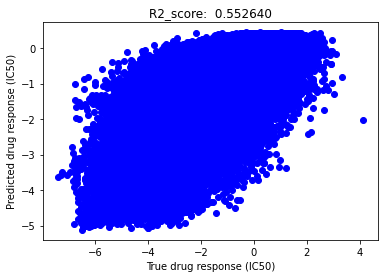

In [28]:
# Draw a scatter chart of true drug response and predicted drug response

plt.scatter(targets, preds, c='b')
plt.xlabel('True drug response (IC50)', color='k')
plt.ylabel('Predicted drug response (IC50)', color='k')
plt.title("R2_score: {0: .6f}".format(r2/len(testLoader)))
plt.show()

## Inference for MLP_w_mutation

In [29]:
trainDataset = LatentDataset(drug_resp[drug_resp.cell_id.isin(train_cells)].reset_index(drop=True),drug_latent,encoded_cell_lines, mutations_df, include_mutation=True   )
validationDataset = LatentDataset(drug_resp[drug_resp.cell_id.isin(val_cells)].reset_index(drop=True),drug_latent,encoded_cell_lines, mutations_df, include_mutation=True   )
testDataset = LatentDataset(drug_resp[drug_resp.cell_id.isin(test_cells)].reset_index(drop=True),drug_latent,encoded_cell_lines, mutations_df, include_mutation=True   )

trainLoader = DataLoader(trainDataset, batch_size=1000, shuffle=True, drop_last=True)
validationLoader = DataLoader(validationDataset, batch_size=1000, drop_last=True)
testLoader = DataLoader(testDataset, batch_size=1000, drop_last=False)

In [30]:
drug_resp_test = drug_resp[drug_resp.cell_id.isin(test_cells)].reset_index(drop=True)

In [31]:
drug_latent_size, ge_latent_size, mutat_size = 56, 1024, 18787
model = MLP_w_mutation(drug_latent_size, ge_latent_size, mutat_size)

In [32]:
model.load_state_dict(torch.load('./trainedModels/MLP_w_mutation_best.pt'))
model.eval()

MLP_w_mutation(
  (geMLP): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): PReLU(num_parameters=1)
  )
  (dMLP): Sequential(
    (0): Linear(in_features=56, out_features=128, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): PReLU(num_parameters=1)
  )
  (mutMLP): Sequential(
    (0): Linear(in_features=18787, out_features=256, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): PReLU(num_parameters=1)
  )
  (combineMLP): Sequential(
    (0): Linear(in_f

In [33]:
if torch.cuda.is_available():
    model = model.cuda()
    
r2, rmse = 0,0
preds, targets = [], []
for batch in testLoader:
    geLatentVec, dLatentVec,mutations, target = batch
    target = target.reshape(-1,1)
    if torch.cuda.is_available():
        geLatentVec = geLatentVec.cuda()
        dLatentVec = dLatentVec.cuda()
        mutations = mutations.cuda()
        target = target.cuda()

    out = model(geLatentVec, dLatentVec, mutations)

    out = out.data.cpu().numpy().tolist()
    target = target.cpu().numpy().tolist()
    r2 += r2_score(target, out)
    rmse += mean_squared_error(target, out)**0.5
    preds.append(out)
    targets.append(target)
    
    
preds = np.vstack(preds)
targets = np.vstack(targets)


In [34]:
np.save('./trainedModels/preds_MLP_w_mutation_best', preds)
np.save('./trainedModels/targets_MLP_w_mutation_best', targets)

In [35]:
drug_resp_test['prediction'] = preds

In [39]:
r2/len(testLoader), len(testLoader)

(0.5642130924772808, 517)

In [40]:
def r2_per_group(data, truth, predicted):
    return r2_score(data[truth], data[predicted])

r2_score_groupby_cell = drug_resp_test.groupby('cell_id').apply(r2_per_group, 'response', 'prediction').sort_values(ascending=False)
r2_score_groupby_drug = drug_resp_test.groupby('broad_id').apply(r2_per_group, 'response', 'prediction').sort_values(ascending=False)

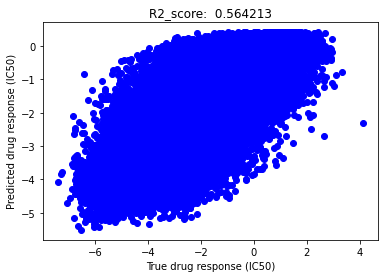

In [41]:
# Draw a scatter chart of true drug response and predicted drug response

plt.scatter(targets, preds, c='b')
plt.xlabel('True drug response (IC50)', color='k')
plt.ylabel('Predicted drug response (IC50)', color='k')
plt.title("R2_score: {0: .6f}".format(r2/len(testLoader)))
plt.show()

## Identify Candidate Drugs to Combine

In [42]:
sample_info = pd.read_csv('../data/sample_info.csv', index_col =0)

In [43]:
crc_cell_lines= sample_info[sample_info.primary_disease == 'Colon/Colorectal Cancer']

In [77]:
crc_Dataset = LatentDataset(drug_resp[drug_resp.cell_id.isin(crc_cell_lines.index)].reset_index(drop=True),drug_latent,encoded_cell_lines, mutations_df, include_mutation=True   )
crc_Loader = DataLoader(crc_Dataset, batch_size=10, num_workers=16, drop_last=False)

In [78]:
if torch.cuda.is_available():
    model = model.cuda()
    
r2, rmse = 0,0
preds, targets = [], []
for batch in crc_Loader:
    geLatentVec, dLatentVec,mutations, target = batch
    target = target.reshape(-1,1)
    if torch.cuda.is_available():
        geLatentVec = geLatentVec.cuda()
        dLatentVec = dLatentVec.cuda()
        mutations = mutations.cuda()
        target = target.cuda()

    out = model(geLatentVec, dLatentVec, mutations)

    out = out.data.cpu().numpy().tolist()
    target = target.cpu().numpy().tolist()
    r2 += r2_score(target, out)
    rmse += mean_squared_error(target, out)**0.5
    preds.append(out)
    targets.append(target)
    
    
preds = np.vstack(preds)
targets = np.vstack(targets)


In [79]:
np.save('./trainedModels/crc_preds_MLP_w_mutation_best', preds)
np.save('./trainedModels/crc_targets_MLP_w_mutation_best', targets)

In [46]:
crc_drug_resp = drug_resp[drug_resp.cell_id.isin(crc_cell_lines.index)].reset_index(drop=True)
crc_drug_resp['prediction'] = preds

In [224]:
# Number of CRC cell lines
drug_resp[drug_resp.cell_id.isin(crc_cell_lines.index)].reset_index(drop=True).cell_id.unique().shape

(35,)

In [94]:
crc_drug_resp.to_csv('./results/crc_drug_resp.csv')

In [51]:
crc_drug_resp = pd.read_csv('./results/crc_drug_resp.csv', index_col=0)

In [302]:
# crc_top_drug_by_avg_respone = crc_drug_resp.groupby('broad_id').mean().sort_values('response', ascending=False).index.values[:1000]
# crc_top_drug_by_avg_prediction = crc_drug_resp.groupby('broad_id').mean().sort_values('prediction', ascending=False).index.values[:1000]

In [270]:
# crc_drug_resp.sort_values('response', ascending=False,inplace=True)
# crc_top_drug_by_respone = crc_drug_resp.broad_id.values[:100]

# crc_drug_resp.sort_values('prediction', ascending=False,inplace=True)
# crc_top_drug_by_prediction = crc_drug_resp.broad_id.values[:100]

In [84]:
Non_crc_Dataset = LatentDataset(drug_resp[~drug_resp.cell_id.isin(crc_cell_lines.index)].reset_index(drop=True),drug_latent,encoded_cell_lines, mutations_df, include_mutation=True   )
Non_crc_Loader = DataLoader(Non_crc_Dataset, batch_size=10, num_workers=16, drop_last=False)

In [88]:
if torch.cuda.is_available():
    model = model.cuda()
    
r2, rmse = 0,0
preds, targets = [], []
for batch in Non_crc_Loader:
    geLatentVec, dLatentVec,mutations, target = batch
    target = target.reshape(-1,1)
    if torch.cuda.is_available():
        geLatentVec = geLatentVec.cuda()
        dLatentVec = dLatentVec.cuda()
        mutations = mutations.cuda()
        target = target.cuda()

    out = model(geLatentVec, dLatentVec, mutations)

    out = out.data.cpu().numpy().tolist()
    target = target.cpu().numpy().tolist()
    r2 += r2_score(target, out)
    rmse += mean_squared_error(target, out)**0.5
    preds.append(out)
    targets.append(target)
    
    
preds = np.vstack(preds)
targets = np.vstack(targets)


In [89]:
np.save('./trainedModels/Non_crc_preds_MLP_w_mutation_best', preds)
np.save('./trainedModels/Non_crc_targets_MLP_w_mutation_best', targets)

In [90]:
preds.shape, drug_resp_test.shape

((2428496, 1), (516123, 4))

In [91]:
Non_crc_drug_resp = drug_resp[~drug_resp.cell_id.isin(crc_cell_lines.index)].reset_index(drop=True)
Non_crc_drug_resp['prediction'] = preds

In [93]:
Non_crc_drug_resp.to_csv('./results/Non_crc_drug_resp.csv')

#### Z-scoring the predictions

In [447]:
# Z-score transformation
num_crc_CL = len(crc_drug_resp.cell_id.unique())
for drug in tqdm(drug_resp.broad_id.value_counts().index.values):
    mu_samples = [Non_crc_drug_resp.loc[Non_crc_drug_resp.broad_id == drug, 'prediction'].sample(num_crc_CL).mean() for _ in range(100)]
    crc_drug_resp.loc[crc_drug_resp.broad_id == drug,'prediction'] = (crc_drug_resp.loc[crc_drug_resp.broad_id == drug,'prediction'] - np.mean(mu_samples))/np.std(mu_samples)

100%|██████████| 100/100 [00:08<00:00, 11.64it/s]

done in 8.58944821357727


In [ ]:
# Using less samples doesn't affect the mean and the std too much

Text(0.5, 1.0, '100 Samples, mu=-0.06, std=0.01')

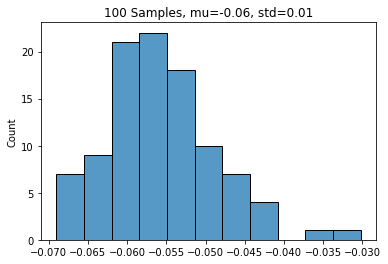

In [448]:
ax = sns.histplot(mu_samples)
ax.set_title(f'100 Samples, mu={np.mean(mu_samples):.2f}, std={np.std(mu_samples):.2f}')

Text(0.5, 1.0, '1000 Samples, mu=-0.06, std=0.01')

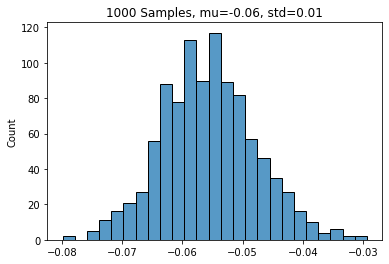

In [444]:
ax = sns.histplot(mu_samples)
ax.set_title(f'1000 Samples, mu={np.mean(mu_samples):.2f}, std={np.std(mu_samples):.2f}')

Text(0.5, 1.0, '10000 Samples, mu=-0.06, std=0.01')

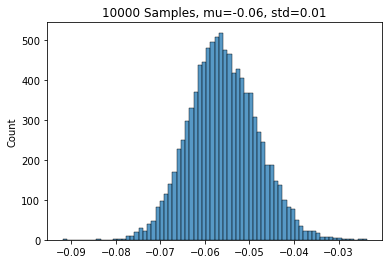

In [446]:
ax = sns.histplot(mu_samples)
ax.set_title(f'10000 Samples, mu={np.mean(mu_samples):.2f}, std={np.std(mu_samples):.2f}')

In [451]:
crc_drug_resp.to_csv('./results/crc_drug_resp_z-scored.csv')

In [52]:
crc_drug_resp = pd.read_csv('./results/crc_drug_resp_z-scored.csv', index_col=0)

#### Use drugs' latent representation to calculate the cosine similarity

In [252]:
drugs_info = pd.read_csv('../data/primary-screen-replicate-treatment-info.csv', sep=',')

In [53]:
drug_latent_copy = drug_latent.copy()
drug_latent_copy.set_index('broad_id', drop=True, inplace=True)
drug_latent_copy.drop('SMILE', axis= 1, inplace=True)

In [62]:
from sklearn.metrics.pairwise import cosine_similarity
drug_sim_df = pd.DataFrame(np.abs(cosine_similarity(drug_latent_copy)), index = drug_latent_copy.index, columns=drug_latent_copy.index)

In [240]:
high_sim_series = ((drug_sim_df > 0.95).sum() > 1)
high_similar_drugs = high_sim_series[high_sim_series ==True].index

drug_tragets = {}
df = drug_sim_df > 0.95

#crc_top_resp_by_respone, crc_top_resp_by_prediction

for id_ in crc_top_resp_by_respone:
    id_traget = drugs_info[drugs_info.broad_id == id_].drop_duplicates('broad_id')['target'].values
    
    if 'BRAF' in id_traget: print(id_)
    sim_drugs = df.columns[df.loc[id_, ]].values
    sim_drugs = [d for d in sim_drugs if d != id_]
    if len(sim_drugs) == 0: continue
    other_tragets = drugs_info[drugs_info.broad_id.isin(list(sim_drugs))].drop_duplicates('broad_id')['target'].values
    inter = list(set(id_traget).intersection(set(other_tragets)))
    if len(inter) > 0:
        drug_tragets[id_] = inter
        if 'BRAF' in drug_tragets[id_] or 'BRAF' in id_traget:
            print(id_)

In [247]:
crc_top_drug_by_respone

array(['BRD-K23925186-001-02-8', 'BRD-K00634421-001-01-0',
       'BRD-K81728688-001-04-4', 'BRD-K22134346-001-24-9',
       'BRD-K07572174-001-39-4', 'BRD-K07881437-001-04-6',
       'BRD-K96159438-001-06-3', 'BRD-K43236057-001-07-1',
       'BRD-K08078237-001-19-8', 'BRD-K43236057-001-07-1'], dtype=object)

In [198]:
id_ = 'BRD-K31866293-001-01-6'
sim_drugs = df.columns[df.loc[id_, ]].values
sim_drugs = [d for d in sim_drugs if d != id_]
for id2 in sim_drugs:
    print(id_, id2,drug_sim_df.loc[id_, id2])

BRD-K31866293-001-01-6 BRD-K32501161-300-06-2 0.9504668059376263
BRD-K31866293-001-01-6 BRD-K93123848-001-04-1 0.9500379255564914
BRD-K31866293-001-01-6 BRD-K38168441-001-03-7 0.9574479751522169


In [195]:
df.columns[df.loc['BRD-K67578145-001-12-1', ]].values

array(['BRD-K75080769-001-01-6', 'BRD-K67578145-001-12-1',
       'BRD-K42221274-003-07-7', 'BRD-K92015269-300-01-2',
       'BRD-K67578145-001-09-7'], dtype=object)

In [452]:
crc_drug_avg_resp = crc_drug_resp.groupby('broad_id').mean()

<AxesSubplot:ylabel='Count'>

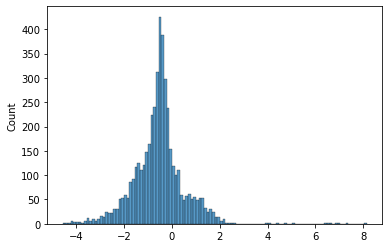

In [455]:
sns.histplot(crc_drug_avg_resp.prediction.values)

<AxesSubplot:ylabel='Count'>

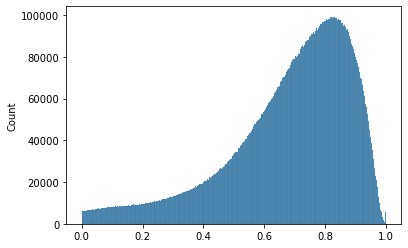

In [379]:
sns.histplot(drug_sim_df.values.reshape(-1))

In [460]:
# Sort the drugs based on their average z-scored predicted reponse on CRC cell lines
crc_sorted_drug_by_avg_respone = crc_drug_resp.groupby('broad_id').mean().sort_values('response', ascending=False).index.values
crc_sorted_drug_by_avg_prediction = crc_drug_resp.groupby('broad_id').mean().sort_values('prediction', ascending=False).index.values

In [ ]:
# I kept only these 4/6 drugs of interest, because they are the only ones that appear on the list of all drugs in the study
names_of_interest = ['5-fluorouracil', 'oxaliplatin', 'irinotecan', 'regorafenib'] 
cgc = pd.read_csv('../data/Census_allThu Jul 30 07_07_22 2020.csv')
promising_drug_targets = ['TP53', 'EGFR', 'UBE2I', 'CCND1', 'TOP1', 'MECP2', 'IMPDH2', 'NOS3', 'XRCC1', 'GNAS', 'VEGFA', 'PTGS2', 'CFH', 'MSH6', 'GSTP1']

In [351]:
# The fitness score function
def drug_comb_score(comb_id, drug_id, drug_response, drug_sim, l1, l2):
    
    score = l1*drug_response.loc[drug_id, 'prediction'] - l2 * drug_sim.loc[comb_id, drug_id].max()
    return score

In [558]:
l1 = 1
drugs_sets = []
for l2 in np.linspace(3, 8, num=10):
    N = [crc_sorted_drug_by_avg_prediction[0]]

    drugs = set(crc_sorted_drug_by_avg_prediction) - set(N)
    print(f'l1={l1:.2f}, l2={l2:.2f}')
    for i in range(50):
        scores = [drug_comb_score(N,d,crc_drug_avg_resp, drug_sim_df,l1,l2  ) for d in list(drugs)]
        idx = np.argmax(scores)
        to_append = list(drugs)[idx]
        N.append(to_append)
        drugs = set(drugs) - set([to_append])
        
    drugs_sets.append(N)
    total_drugs = drugs_info.name.dropna().unique().shape[0]
    cov = len(set(drugs_info[drugs_info.broad_id.isin(N)].target.dropna().values))/total_drugs
    mutex = len(set(drugs_info[drugs_info.broad_id.isin(N)].target.dropna().values))/drugs_info[drugs_info.broad_id.isin(N)].target.dropna().values.shape[0]
    cgc_overlap = len(set(drugs_info[drugs_info.broad_id.isin(N)].target.dropna().values).intersection(set(cgc['Gene Symbol'].values)))
    prom_overlap = len(set(drugs_info[drugs_info.broad_id.isin(N)].target.dropna().values).intersection(set(promising_drug_targets)))
    names_overlap = len(set(drugs_info[drugs_info.broad_id.isin(N)].name.dropna().values).intersection(set(names_of_interest)))
    
    print(f'cov/mutex={cov:.4f}/{mutex:.4f}, cgc_overlap={cgc_overlap},prom_overlap={prom_overlap}, names_overlap={names_overlap}\n')
    

l1=1.00, l2=3.00
cov/mutex=0.0077/0.3070, cgc_overlap=2,prom_overlap=0, names_overlap=0

l1=1.00, l2=3.56
cov/mutex=0.0077/0.3070, cgc_overlap=2,prom_overlap=0, names_overlap=0

l1=1.00, l2=4.11
cov/mutex=0.0077/0.3070, cgc_overlap=2,prom_overlap=0, names_overlap=1

l1=1.00, l2=4.67
cov/mutex=0.0077/0.3070, cgc_overlap=3,prom_overlap=0, names_overlap=1

l1=1.00, l2=5.22
cov/mutex=0.0073/0.3056, cgc_overlap=3,prom_overlap=0, names_overlap=1

l1=1.00, l2=5.78
cov/mutex=0.0073/0.3143, cgc_overlap=1,prom_overlap=0, names_overlap=1

l1=1.00, l2=6.33
cov/mutex=0.0071/0.3137, cgc_overlap=1,prom_overlap=0, names_overlap=1

l1=1.00, l2=6.89
cov/mutex=0.0071/0.3137, cgc_overlap=1,prom_overlap=0, names_overlap=1

l1=1.00, l2=7.44
cov/mutex=0.0073/0.3056, cgc_overlap=1,prom_overlap=0, names_overlap=1

l1=1.00, l2=8.00
cov/mutex=0.0066/0.3030, cgc_overlap=1,prom_overlap=0, names_overlap=1



In [549]:
# pairwise_sim = 0
# for i, d1 in enumerate(drugs_sets[0]):
#     for j,d2 in enumerate(drugs_sets[0][i:]):
#         pairwise_sim += drug_sim_df.loc[d1,d2]
# pairwise_sim/(50*49)

0.3574935108245989

In [585]:
# drugs_info.loc[(drugs_info.broad_id.isin(drugs_sets[3])),].drop_duplicates('broad_id').to_csv('./results/canditate_drugs_l2_4.67.csv')
drugs_info.loc[(drugs_info.broad_id.isin(drugs_sets[3])),].drop_duplicates('broad_id')

,column_name,broad_id,name,dose,perturbation_type,Unnamed: 5,Unnamed: 6,screen_id,detection_plate,compound_plate,well,detection_plate_scan_time,vendor_id,purity,moa,target,disease.area,indication,smiles,phase
157,PREP001_X1:G14::HTS,BRD-K03289018-001-02-7,CCT137690,2.500000,experimental_treatment,NaN,NaN,HTS,PREP001_X1,PREP001,G14,2/11/16 10:09,S2744,85.27,Aurora kinase inhibitor,"AURKA, AURKB, AURKC",NaN,NaN,CN1CCN(CC1)c1ccc(cc1)-c1nc2c(N3CCN(Cc4cc(C)on4...,Preclinical
243,PREP001_X1:K04::HTS,BRD-K54395039-001-01-7,PR-619,2.500000,experimental_treatment,NaN,NaN,HTS,PREP001_X1,PREP001,K04,2/11/16 10:09,S7130,82.97,DUB inhibitor,NaN,NaN,NaN,"Nc1nc(N)c(SC#N)cc1SC#N, Nc1nc(N)c(SC#N)cc1SC#N",Preclinical
307,PREP001_X1:M20::HTS,BRD-K55305701-001-01-2,SC-144,2.500000,experimental_treatment,NaN,NaN,HTS,PREP001_X1,PREP001,M20,2/11/16 10:09,S7124,88.57,P glycoprotein inhibitor,NaN,NaN,NaN,"Fc1ccc2c(c1)nc(NNC(=O)c1cnccn1)c1cccn21, Fc1cc...",Preclinical
353,PREP001_X1:O18::HTS,BRD-K42436189-001-01-2,AZ20,2.500000,experimental_treatment,NaN,NaN,HTS,PREP001_X1,PREP001,O18,2/11/16 10:09,S7050,97.81,ATR kinase inhibitor,"ATR, MTOR",NaN,NaN,C[C@@H]1COCCN1c1cc(nc(n1)-c1cccc2[nH]ccc12)C1(...,Preclinical
357,PREP001_X1:O22::HTS,BRD-K59831625-001-01-6,LDN-212854,2.500000,experimental_treatment,NaN,NaN,HTS,PREP001_X1,PREP001,O22,2/11/16 10:09,S7147,83.37,bone morphogenic protein inhibitor,"ABL1, ACVR1, RIPK2",NaN,NaN,C1CN(CCN1)c1ccc(cc1)-c1cnc2c(cnn2c1)-c1cccc2nc...,Preclinical
1181,PREP002_X1:B06::HTS,BRD-A01412266-001-01-0,hydroxypropyl-beta-cyclodextrin,2.500000,experimental_treatment,NaN,NaN,HTS,PREP002_X1,PREP002,B06,2/11/16 12:39,16169,98.32,NaN,NaN,NaN,NaN,CC(O)COC[C@H]1O[C@@H]2O[C@@H]3[C@@H](COCC(C)O)...,Phase 2
1221,PREP002_X1:C22::HTS,BRD-K33379087-001-07-5,tivantinib,2.500000,experimental_treatment,NaN,NaN,HTS,PREP002_X1,PREP002,C22,2/11/16 12:39,HY-50686,98.79,tyrosine kinase inhibitor,MET,NaN,NaN,O=C1NC(=O)[C@H]([C@@H]1c1c[nH]c2ccccc12)c1cn2C...,Phase 3
2325,PREP003_X1:A22::HTS,BRD-K25312248-001-01-5,matrine,2.500000,experimental_treatment,NaN,NaN,HTS,PREP003_X1,PREP003,A22,2/11/16 11:08,S2322,92.78,opioid receptor agonist,OPRK1,NaN,NaN,O=C1CCC[C@@H]2[C@@H]3CCCN4CCC[C@H](CN12)[C@@H]34,Phase 2
2477,PREP003_X1:H06::HTS,BRD-K85402309-001-06-6,dovitinib,2.500000,experimental_treatment,NaN,NaN,HTS,PREP003_X1,PREP003,H06,2/11/16 11:08,S1018,76.83,"EGFR inhibitor, FGFR inhibitor, FLT3 inhibitor...","CSF1R, EGFR, FGFR1, FGFR2, FGFR3, FLT1, FLT3, ...",NaN,NaN,CN1CCN(CC1)c1ccc2nc([nH]c2c1)-c1c(N)c2c(F)cccc...,Phase 3
2651,PREP003_X1:O12::HTS,BRD-A05906449-004-01-1,lappaconite,2.500000,experimental_treatment,NaN,NaN,HTS,PREP003_X1,PREP003,O12,2/11/16 11:08,S2387,90.14,sodium channel blocker,NaN,NaN,NaN,CCN1C[C@@]2(CC[C@@H](OC)[C@@]34[C@H]5C[C@H]6[C...,Phase 2


In [552]:
names_of_interest_broad_id = drugs_info.loc[drugs_info.name.isin(names_of_interest), 'broad_id'].unique()
ss = crc_drug_resp.groupby('broad_id').mean()
ss.loc[:, 'rank_resp'] = np.argsort(ss.response.values)[::-1].argsort()
ss.loc[:, 'rank_pred'] = np.argsort(ss.prediction.values)[::-1].argsort()
ss.loc[names_of_interest_broad_id, ]

,response,prediction,rank_resp,rank_pred
broad_id,,,,
BRD-K16730910-001-07-3,-0.176945,0.311902,3318,687
BRD-K78960041-001-03-2,-1.482708,1.128253,4446,273
BRD-K78960041-001-05-7,-0.655747,1.150518,4220,258
BRD-K08547377-394-03-5,-1.881729,1.735990,4490,73
BRD-K24844714-001-24-5,-0.627077,0.596502,4196,537


In [ ]:
# Drugs Approved for Colon and Rectal Cancer
'''Avastin (Bevacizumab)
Bevacizumab
Camptosar (Irinotecan Hydrochloride)
Capecitabine
Cetuximab
Cyramza (Ramucirumab)
Eloxatin (Oxaliplatin)
Erbitux (Cetuximab)
5-FU (Fluorouracil Injection)
Fluorouracil Injection
Ipilimumab
Irinotecan Hydrochloride
Keytruda (Pembrolizumab)
Leucovorin Calcium
Lonsurf (Trifluridine and Tipiracil Hydrochloride)
Mvasi (Bevacizumab)
Nivolumab
Opdivo (Nivolumab)
Oxaliplatin
Panitumumab
Pembrolizumab
Ramucirumab
Regorafenib
Stivarga (Regorafenib)
Trifluridine and Tipiracil Hydrochloride
Vectibix (Panitumumab)
Xeloda (Capecitabine)
Yervoy (Ipilimumab)
Zaltrap (Ziv-Aflibercept)
Zirabev (Bevacizumab)
Ziv-Aflibercept
'''

#Drug Combinations Used in Colon Cancer
'''
CAPOX
FOLFIRI
FOLFIRI-BEVACIZUMAB
FOLFIRI-CETUXIMAB
FOLFOX
FU-LV
XELIRI
XELOX
'''